# Experimental phantom for PRF estimation

In this notebook, the PRF is estimated from three Teledyne DALSA Xineos-3131
detectors using a data set of repeated radiographs.

This data set is available for download at 10.5281/zenodo.15383254.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tifffile import tifffile
import imageio

## 1. Loading
First, the data set is loaded into memory.

In [2]:
PROJECTION_FILE_REGEX = os.sep.join(
    ["camera ([1-3])", "img_([0-9]{1,6})\\.tif$"])

def _collect_fnames(
    path: str,
    regex: str = PROJECTION_FILE_REGEX,
):
    if not os.path.exists(path):
        raise IOError(f"The path to {path} does not seem to exist.")

    results, results_filenames = [], []
    regex = re.compile(regex)
    print(path)
    for root, dirs, files in os.walk(path):
        for file in files:
            full_filename = os.path.join(root, file)
            match = regex.search(full_filename)
            if match is not None:
                groups = match.groups()

                tmp_result = [None] * len(groups)
                for i, group in enumerate(groups):
                    if not group.isdigit():
                        raise Exception(
                            "The regex captured a non-digit, cannot proceed."
                        )

                    tmp_result[i] = int(group)

                results.append(tmp_result)
                results_filenames.append(full_filename)

    return results, results_filenames


def load(
    path: str,
    time_range: range = None,
    time_offsets = None,
    regex: str = PROJECTION_FILE_REGEX,
    dtype=np.float32,
    verbose: bool = False,
    cameras = (1, 2, 3),
    detector_rows = None,
):
    """Load a stack of data from disk using a pattern."""

    results, results_filenames = _collect_fnames(path, regex)
    # Check the results for continuity in the subsequences range
    lists = list(zip(*results))

    first_cam = cameras[0]
    amount_matches = lists[0].count(first_cam)
    assert amount_matches > 0
    for cam in cameras:
        assert amount_matches == lists[0].count(cam), \
            (f"Found {amount_matches} but expected {lists[0].count(cam)}, "
             f"each directory should have the same number of files.")

    if time_range is None:
        time_range = range(np.min(lists[1]), np.max(lists[1]) + 1)

    # load into results
    im_shape = list(imageio.v2.imread(results_filenames[0]).shape)
    if detector_rows is None:
        rows = slice(0, im_shape[0])
    else:
        rows = slice(detector_rows.start, detector_rows.stop)
    ims = np.zeros((len(time_range), len(cameras), *im_shape), dtype=dtype)

    # make a dictionary with in the first key the detector, and second key
    # the timestep
    nested_dict = {i: {} for i in cameras}
    for i, ((cam_id, t), filename) in enumerate(
        zip(results, results_filenames)):
        if cam_id in cameras:
            t_actual = t - time_offsets[cam_id] if time_offsets is not None else t
            nested_dict[cam_id][t_actual] = filename

    # check if wanted timesteps are in the dict, and load them
    for t_i, t in enumerate(time_range) if verbose else enumerate(time_range):
        for d_i, d in enumerate(nested_dict.keys()):
            if not t in nested_dict[d]:
                raise FileNotFoundError(
                    f"Could not find timestep {t} at path {nested_dict[d][t]} "
                    f"from detector {d} in directory {path}."
                )
            if verbose:
                print("Reading ", nested_dict[d][t])
            # faster but imageio may be easier to install
            ims[t_i, d_i, rows] = \
                tifffile.imread(nested_dict[d][t], maxworkers=1)[
                # imageio.v2.imread(nested_dict[d][t])[
                        detector_rows]

    return np.ascontiguousarray(ims)

## 2. Manual dataset checks

It is always a good idea to examine the data set for suitability for PRF
estimation.
 - A first condition is that **all the frames in the data set must
have the same signal**. A simple way is to browse through the data set, or to
inspect the average frame.
 - A second condition is that **the variance of the noise must not be affected**. This
could, for instance, happen with detector clipping or nearby shielded edges
of the instrument, which would be visited as regions of lowered variance.

data/foamballs


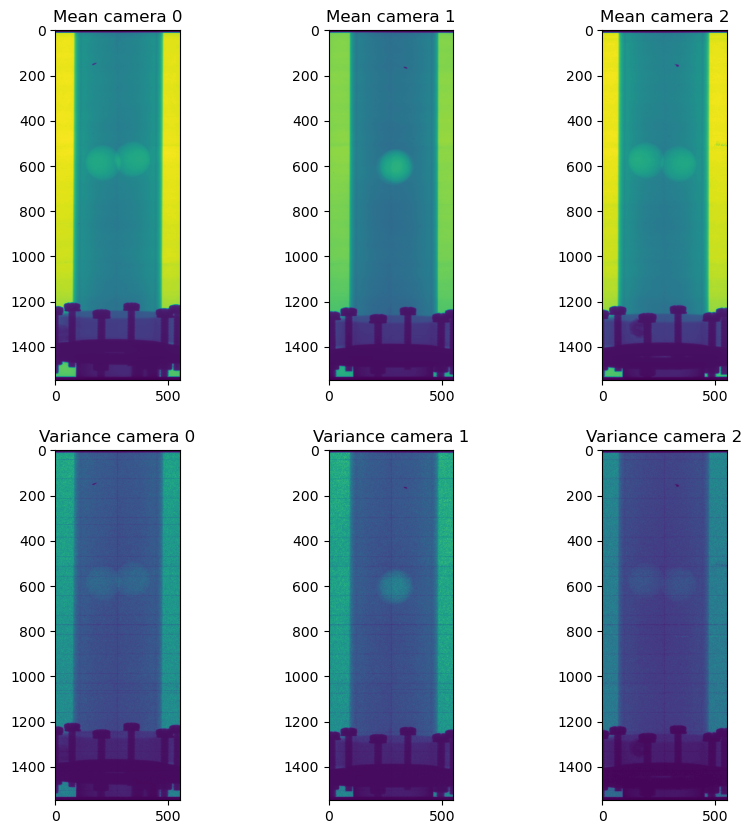

In [4]:
data = load(
    "data/foamballs",
    range(1, 1000, 10)
)
# data = data[..., 400:800, 100:400]

# Manually check: avoid teared frames in the first few images of the dataset!
fig, axs = plt.subplots(2, data.shape[1], figsize=(10, 10))
for c in range(data.shape[1]):
    axs[0, c].set_title(f"Mean camera {c}")
    axs[0, c].imshow(np.mean(data[:, c, ...], axis=0))
    axs[1, c].set_title(f"Variance camera {c}")
    axs[1, c].imshow(np.var(data[:, c, ...], axis=0))

del fig, axs
del data

**Temporal drift** can occur if the beam intensity is not stable,
in which case the photon counts rise over time in a static scene.
This could disturb the PRF estimation. The plot below visualizes the temporal drift.

When there is a temporal drift, we recommend to compute the PRF using
radiograph differences, rather than by subtracting the mean radiograph.


data/foamballs


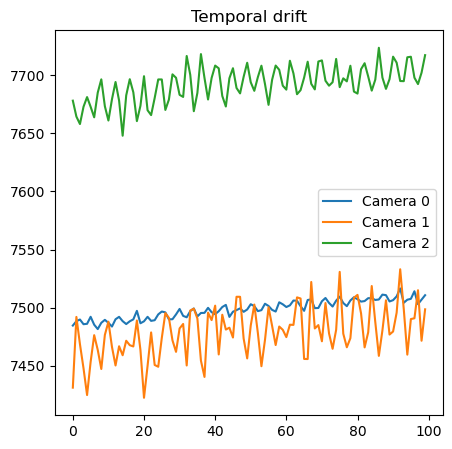

In [5]:
data = load(
    "data/foamballs",
    range(1, 1001, 10)
)

# This shows potential time-trends, motivating altvar
plt.figure(figsize=(5, 5))
plt.title("Temporal drift")
for c in range(data.shape[1]):
    plt.plot(np.mean(data[:, c], axis=(1,2)),
             label=f"Camera {c}")
plt.legend()
plt.show()

del data


## 3. Estimation of the correlation PSF

In this case, the PRF is computed via radiograph differences. It is usually
beneficial to take a large number of frames in the estimation.


In [6]:
from scintillatordecorrelator import (estimate_autocorrelation,
    solve_kernel)

data = load(
    "data/foamballs",
    range(1, 401, 1)
)

auto_kernels = []
prfs = []

for c in range(data.shape[1]):
    print(f"Estimating PRF for camera {c}...")
    # we use differences instead of mean because of temporal drift:
    h_conv_h = estimate_autocorrelation(
        data[:, c],
        estimator='differences',
        out_shape=(13, 13))
    h = solve_kernel(h_conv_h)
    auto_kernels.append(h_conv_h)
    prfs.append(h / np.sum(h))

data/foamballs
Estimating PRF for camera 0...
Estimating PRF for camera 1...
Estimating PRF for camera 2...


It is expected that the found and normalized PSFs are almost the same for all the cameras.

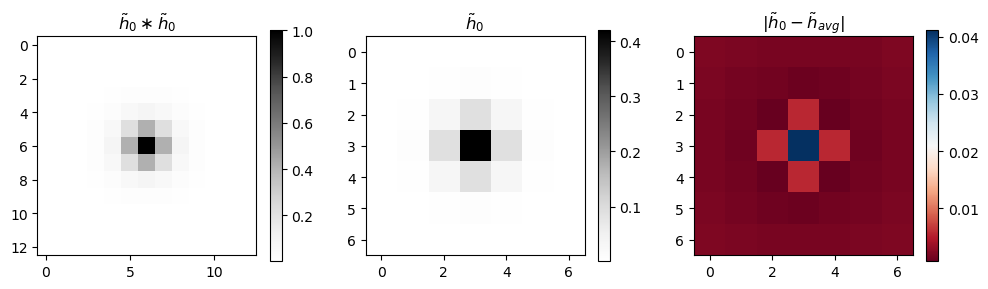

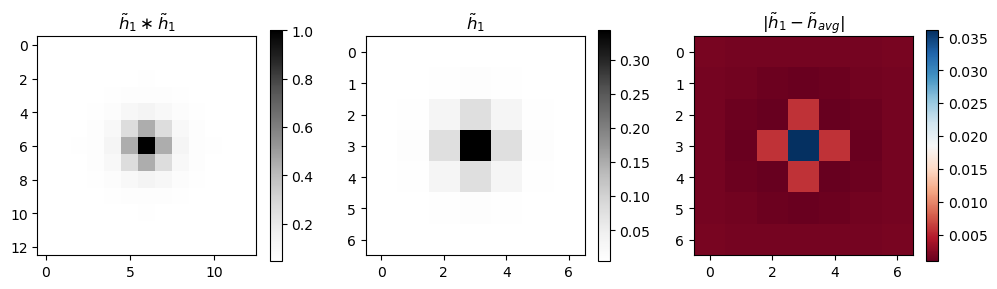

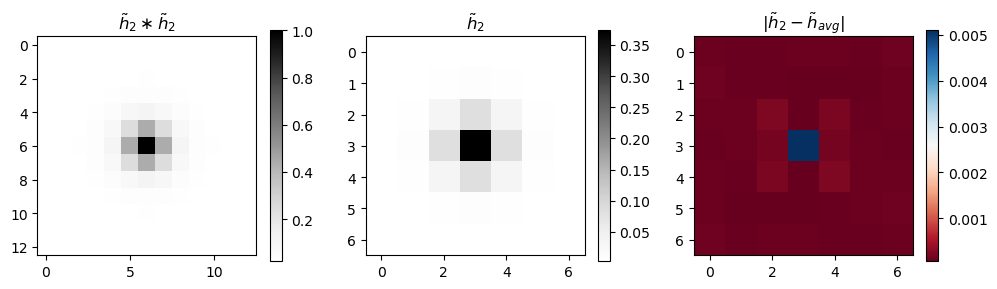

In [7]:
h_avg = np.mean(np.asarray(prfs), axis=0)

for c, (h_conv_h, h) in enumerate(zip(auto_kernels, prfs)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].set_title(f'$\\tilde h_{c} \\ast \\tilde h_{c}$')
    im0 = axs[0].imshow(h_conv_h, cmap='Greys')
    plt.colorbar(im0, ax=axs[0])
    axs[1].set_title(f'$\\tilde h_{c}$')
    im1 = axs[1].imshow(h, cmap='Greys')
    plt.colorbar(im1, ax=axs[1])
    axs[2].set_title(f'$|\\tilde h_{c}' + '- \\tilde h_{avg}|$')
    im2 = axs[2].imshow(np.abs(h - h_avg), cmap='RdBu')
    plt.colorbar(im2, ax=axs[2])

plt.show()

del fig, axs, im0, im1, im2

## 4. Dataset deconvolution


The found PRF can now be used to perform a deconvolution. This will reduce
the correlation of noise and sharpen the signal.

In [8]:
from scintillatordecorrelator import Deconvolve

data = load(
    "data/foamballs",
    range(1, 301),
    cameras=(1,),
)[:, :, 100:-100, :]
print(data.shape)
data.flags.writeable = False

deconvolved = np.empty_like(data)
for c in range(data.shape[1]):
    deconv = Deconvolve(prfs[c], 0.0)
    for t in range(data.shape[0]):
        deconvolved[t, c] = deconv(data[t, c])

data/foamballs
(300, 1, 1348, 550)


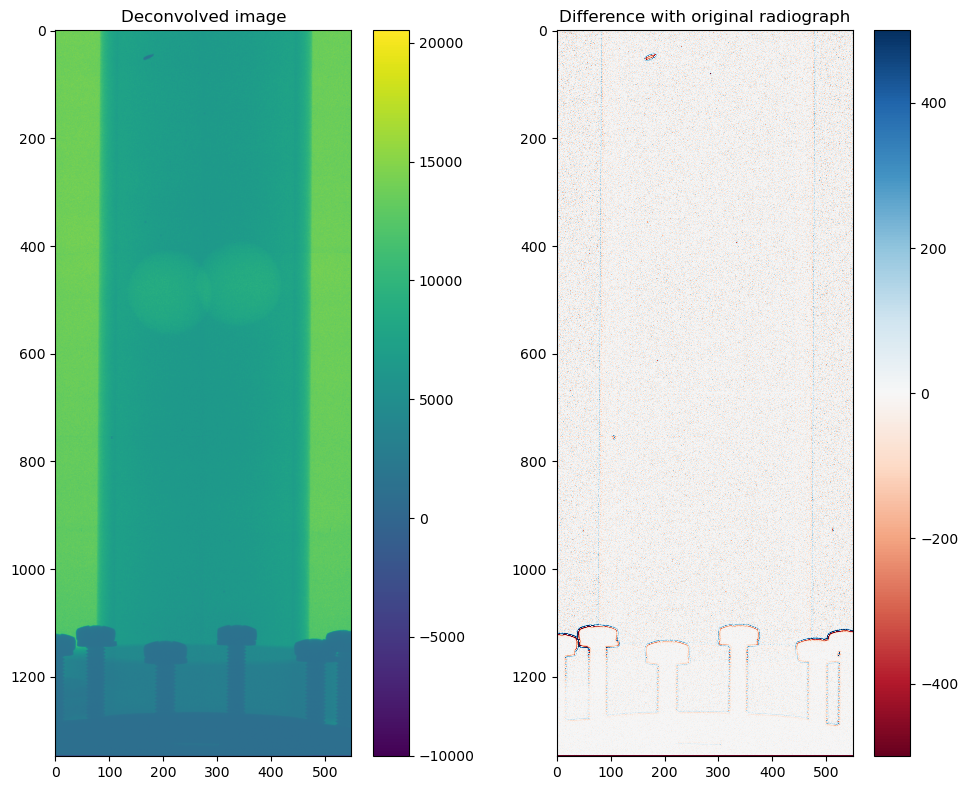

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ax1.set_title("Deconvolved image")
im = ax1.imshow(deconvolved[0, 0])
plt.colorbar(im, ax=ax1)
ax2.set_title("Difference with original radiograph")
im = ax2.imshow((deconvolved[0, 0] - data[0, 0]), vmin=-500, vmax=500,
                cmap='RdBu')
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

## 5. Check correlation maps

To see if deconvolution with the estimated PRF was effective at removing
correlations, we compute a **correlation map**. This describes the local
correlations of each pixel with its direct neighborhood. For example,
when a pixel in the map has value 3, it means that its noise value appears
300\% in the surrounding pixels.

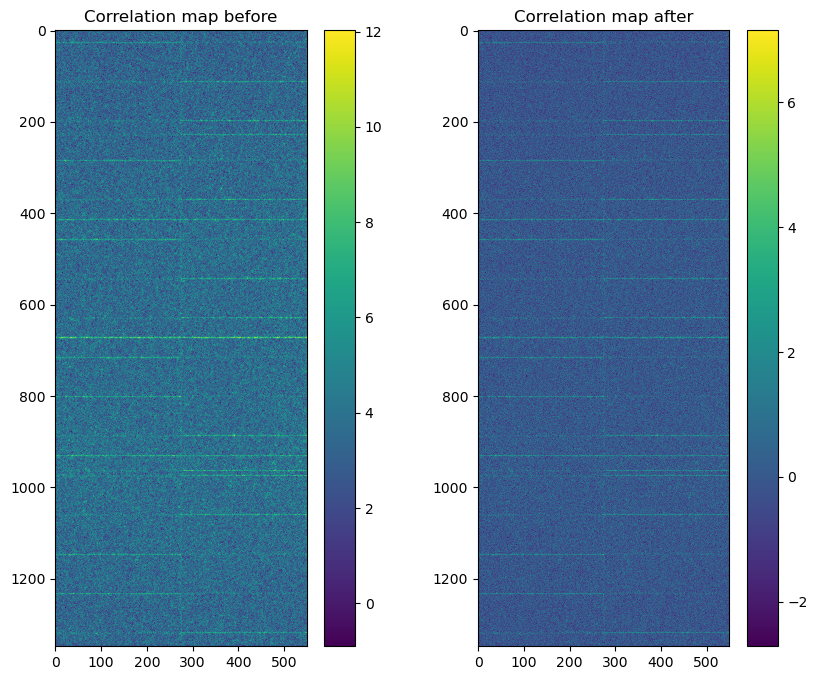

In [13]:
from scintillatordecorrelator import correlation_map

before = correlation_map(
    data[:, 0], estimator='differences', dist=(7, 7))
after = correlation_map(
    deconvolved[:, 0], estimator='differences', dist=(7, 7))

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].set_title("Correlation map before")
im0 = axs[0].imshow(before, interpolation='none')
plt.colorbar(im0, ax=axs[0])

axs[1].set_title("Correlation map after")
im1 = axs[1].imshow(after, interpolation='none')
plt.colorbar(im1, ax=axs[1])
plt.show()


Finally, we can get an impression of how much correlation was reduced by computing
the histogram of values before and after deconvolution.

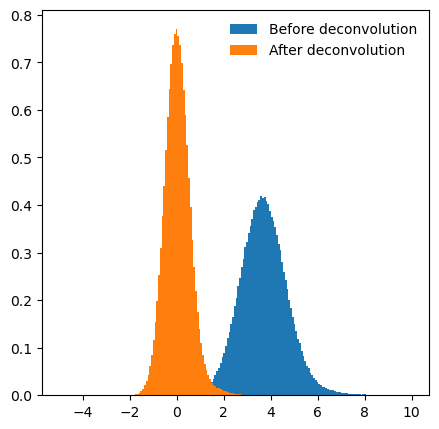

In [12]:
plt.figure(figsize=(5, 5))
plt.hist(before.flat,
         bins=200, range=(-5.0, 10.0),
         label=f'Before deconvolution',
         density=True)
plt.hist(after.flat,
         bins=200, range=(-5.0, 10),
         label=f'After deconvolution',
         density=True)
plt.legend(frameon=False)
plt.show()